In [2]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
import calendar
import os.path

import dask.array as da
from dask.delayed import delayed
from sklearn.model_selection import train_test_split
import gc

from tensorflow.keras import layers, regularizers, optimizers

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Add, LayerNormalization, 
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ConvLSTM2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import UpSampling2D



2023-08-10 21:47:25.601359: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU')


GPU


In [4]:
import gdown
# Replace 'FILE_ID' with the actual file ID and 'output_filename.extension' with the desired filename and extension
output_filename = 'sst_mur.nc'
url = 'https://drive.google.com/uc?id=1-EvB4NllJ2F27YRBRzhS67Ec3eBxEUp9'
gdown.download(url, output_filename, quiet=False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1-EvB4NllJ2F27YRBRzhS67Ec3eBxEUp9
From (redirected): https://drive.google.com/uc?id=1-EvB4NllJ2F27YRBRzhS67Ec3eBxEUp9&confirm=t&uuid=19d75b50-1718-47dc-905a-687231721cdd
To: /work/ab0995/a270226/sst_data/sst_mur.nc
100%|██████████| 2.02G/2.02G [01:04<00:00, 31.4MB/s]


'sst_mur.nc'

Adjust the timesteps

In [4]:
modis_ds_sst_tr = xr.open_dataset(output_filename)
modis_ds_sst_tr = modis_ds_sst_tr.sel(time = slice('2010-06-01','2017-09-01'))

Preprocessing data (normalisation, ect...)

In [5]:
def preprocess_day_data(day_data):
    day_data = da.squeeze(day_data)
    mean_val = da.nanmean(day_data).compute()  # compute here to get scalar value
    return day_data - mean_val

def preprocess_data(zarr_ds, chunk_size=200):
    total_len = zarr_ds['analysed_sst'].shape[0]
    chunk_shape = (chunk_size,) + zarr_ds['analysed_sst'].shape[1:]  # Adjusted chunking
    chunks = []

    for start_idx in range(0, total_len, chunk_size):
        end_idx = min(start_idx + chunk_size, total_len)
        
        # Directly slice the dask array without wrapping it with da.from_array again
        chunk = zarr_ds['analysed_sst'][start_idx:end_idx]
        
        processed_chunk = chunk.map_blocks(preprocess_day_data)
        
        # Use da.where to replace NaNs with 0.0
        processed_chunk = da.where(da.isnan(processed_chunk), 0.0, processed_chunk)
        
        chunks.append(processed_chunk)

    return da.concatenate(chunks, axis=0)

processed_data = preprocess_data(modis_ds_sst_tr)
processed_data

def prepare_data_from_processed(processed_data, window_size=5): 
    length = processed_data.shape[0]
    X, y = [], []

    for i in range(length - window_size):
        X.append(processed_data[i:i+window_size])
        y.append(processed_data[i+window_size])

    X, y = da.array(X), da.array(y)
    return X, y

X, y = prepare_data_from_processed(processed_data)

Splitting the dataset into train, val and test datasets

In [6]:
def time_series_split(X, y, train_ratio=0.7, val_ratio=0.2):
    total_length = X.shape[0]
    
    # Compute end indices for each split
    train_end = int(total_length * train_ratio)
    val_end = int(total_length * (train_ratio + val_ratio))
    
    X_train = X[:train_end]
    y_train = y[:train_end]
    
    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]
    
    X_test = X[val_end:]
    y_test = y[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = time_series_split(X, y)

Model architecture

In [7]:

def create_improved_model(input_shape=(5, 401, 451, 1)):
    model = Sequential()

    # ConvLSTM layer
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                         input_shape=input_shape,
                         padding='same', return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Additional Conv2D layers
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='linear'))

    return model

model = create_improved_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 401, 451, 32)      38144     
                                                                 
 batch_normalization (BatchN  (None, 401, 451, 32)     128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 401, 451, 32)      0         
                                                                 
 conv2d (Conv2D)             (None, 401, 451, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 401, 451, 64)     256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 401, 451, 64)      0

2023-08-10 19:24:11.028158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 19:24:11.427778: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78999 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:03:00.0, compute capability: 8.0


Compilation the model

In [10]:
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(32)

Model training

In [9]:
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[early_stop])

Epoch 1/20


2023-08-10 21:49:28.136245: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


58/58 [==============================] - 107s 1s/step - loss: 0.0894 - mse: 0.0894 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 2/20
58/58 [==============================] - 53s 907ms/step - loss: 0.0826 - mse: 0.0826 - val_loss: 0.0507 - val_mse: 0.0507
Epoch 3/20
58/58 [==============================] - 53s 906ms/step - loss: 0.0818 - mse: 0.0818 - val_loss: 0.0463 - val_mse: 0.0463
Epoch 4/20
58/58 [==============================] - 53s 906ms/step - loss: 0.0854 - mse: 0.0854 - val_loss: 0.0464 - val_mse: 0.0464
Epoch 5/20
58/58 [==============================] - 53s 905ms/step - loss: 0.0823 - mse: 0.0823 - val_loss: 0.0497 - val_mse: 0.0497
Epoch 6/20
58/58 [==============================] - 53s 904ms/step - loss: 0.0833 - mse: 0.0833 - val_loss: 0.0521 - val_mse: 0.0521
Epoch 7/20
58/58 [==============================] - 53s 905ms/step - loss: 0.0817 - mse: 0.0817 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 8/20
58/58 [==============================] - 53s 906ms/step - loss: 0.0816 

Run it only once to create a land mask

In [47]:
def create_land_mask(data): 
    data[data==0] = np.nan
    land_mask = np.isnan(data)
    return (land_mask)

land_mask_resized = create_land_mask(X[0][0].compute())

np.save('land_mask.npy', land_mask_resized)

Postprocessing and plotting functions

In [11]:
def preprocess_vis_input_data(day_data):
    day_data = np.squeeze(day_data)
    mean_val = np.nanmean(day_data)
    processed_data = day_data - mean_val
    # Replace NaNs with 0.0
    processed_data = np.where(np.isnan(processed_data), 0.0, processed_data)
    return processed_data

def postprocess_prediction(prediction, input_data):
    # Find positions where the last day of input_data is 0
    land_mask = np.load('land_mask.npy')
    # Set those positions in the prediction to NaN
    prediction[land_mask] = np.nan
    
    # Add back the historical mean
    mean_val = np.nanmean(input_data)
    prediction = np.where(np.isnan(prediction), np.nan, prediction + mean_val)
    
    return prediction

def predict_and_plot(date_to_predict, window_size, model, dataset, plot=True):
    # Step 1: Select the time window
    time_index = np.where(dataset['time'].values == np.datetime64(date_to_predict))[0][0]
    input_data_raw = dataset['analysed_sst'][time_index-window_size:time_index].values
    true_output_raw = dataset['analysed_sst'][time_index].values
    print(input_data_raw.shape)
    print(true_output_raw.shape)
    # Preprocess the input data
    input_data = np.array([preprocess_vis_input_data(day) for day in input_data_raw])
    
    # Step 2: Make prediction
    prediction = model.predict(input_data[np.newaxis, ...])[0]
    
    # Postprocess the prediction
    prediction_postprocessed = postprocess_prediction(prediction, input_data_raw)
    print(prediction_postprocessed.shape)
    # Step 3: Visualize
    if plot:
        # Determine common scale for all plots
        input_data_raw = input_data_raw[..., np.newaxis]
        true_output_raw = true_output_raw[np.newaxis, ..., np.newaxis]
        prediction_postprocessed = prediction_postprocessed[np.newaxis, ...]
        
        all_data = np.concatenate([input_data_raw, prediction_postprocessed, true_output_raw])
        vmin = np.nanmin(all_data)
        vmax = np.nanmax(all_data)
        
        def plot_sample(sample, title='',reverse = False):
            sample_2d = np.squeeze(sample)
            plt.imshow(sample_2d, cmap='viridis', vmin=vmin, vmax=vmax)
            if reverse == True:
                plt.gca().invert_yaxis()
            plt.title(title)
            plt.colorbar()
            plt.show()

        # show input frames
        for i, frame in enumerate(input_data_raw):
            plot_sample(frame, title=f'Input Frame {i+1} ({dataset["time"].values[time_index-window_size+i]})',reverse = True)
        
        # show predicted output
        plot_sample(prediction_postprocessed, title=f'Predicted Output ({date_to_predict})',reverse = True)
        
        # show true output
        plot_sample(true_output_raw, title=f'True Output ({date_to_predict})',reverse = True)

    return input_data_raw, prediction_postprocessed, true_output_raw

In [12]:
def compute_mse(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    squared_diff = (y_true[mask] - y_pred[mask]) ** 2
    return np.mean(squared_diff)

In [13]:
model.save('CNNLSTM_2002_2010_and_2010_2017.keras')

Make the prediction

(5, 401, 451)
(401, 451)
1/1 [==============================] - 1s 598ms/step
(401, 451, 1)


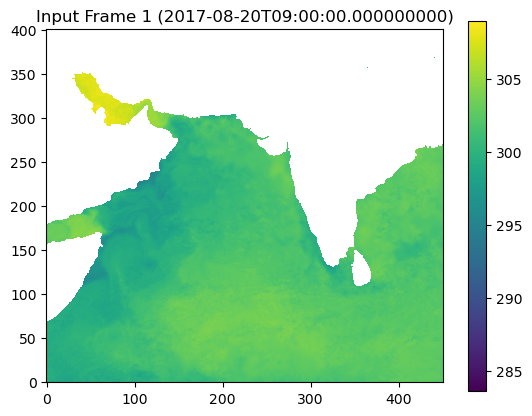

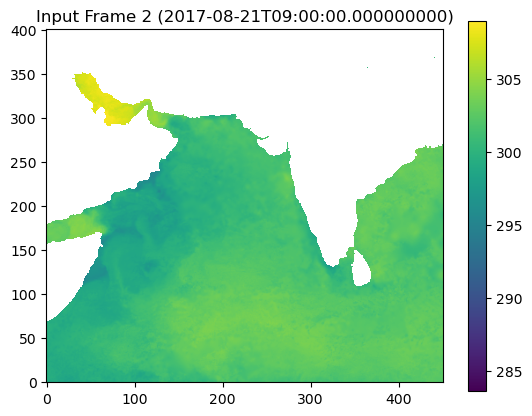

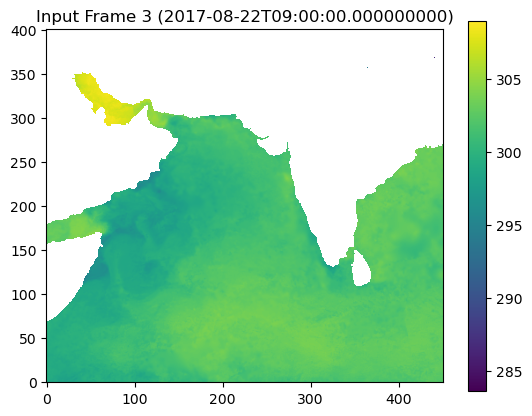

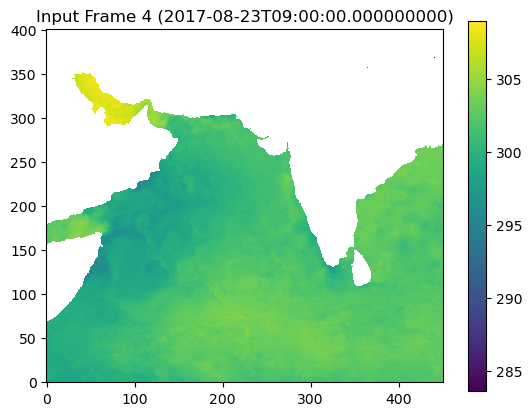

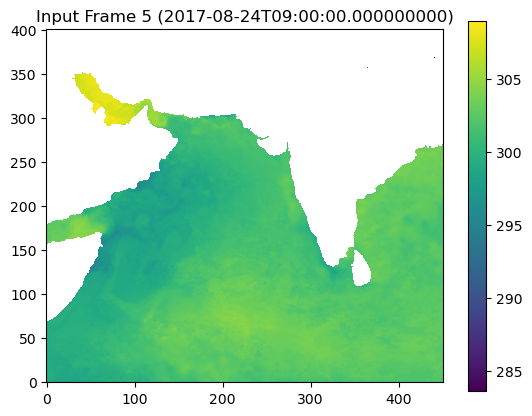

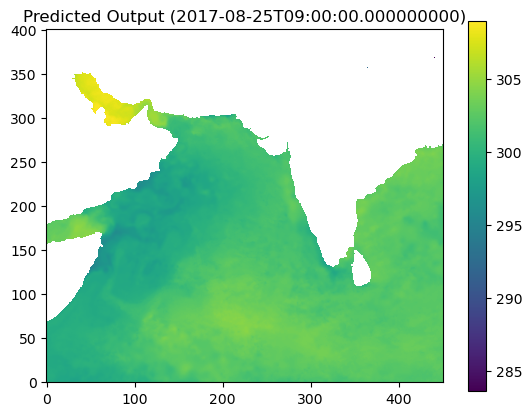

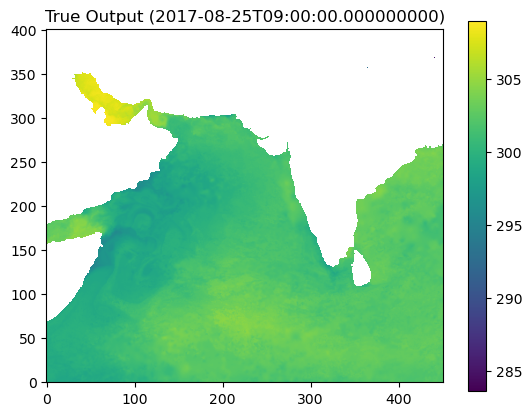

MSE between Predicted Output and True Output: 0.05302172526717186
MSE between Last Input Frame and True Output: 0.0559769906103611


In [14]:
date_to_predict = '2017-08-25T09:00:00.000000000'
window_size = 5
input_data, predicted_output, true_output = predict_and_plot(date_to_predict, window_size, model, modis_ds_sst_tr)

predicted_mse = compute_mse(true_output, predicted_output)
print(f"MSE between Predicted Output and True Output: {predicted_mse}")

last_input_frame = input_data[-1]
last_input_frame_2d = np.squeeze(last_input_frame)
true_output_2d = np.squeeze(true_output)
last_frame_mse = compute_mse(true_output_2d, last_input_frame_2d)
print(f"MSE between Last Input Frame and True Output: {last_frame_mse}")